# TorchVision Instance Segmentation


Здесь будем дообучать [Mask R-CNN](https://arxiv.org/abs/1703.06870) на новом наборе данных: [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). Он содержит 170 изображений с 345 пешеходами на них. Таже будет проилюстрирован процесс подготовки данных, обучения, и подсчёта метрик точности.



## Определения набора данных

Кастомный набор данных для нашей задачи будет наследоваться от `torch.utils.data.Dataset`, и реализовавать `__len__` и `__getitem__` функции.

`__getitem__` должен возвращать:

* image: PIL Image (H, W)
* target: словарь
    * `boxes` (`FloatTensor[N, 4]`): координаты `N` ббоксов в `[x0, y0, x1, y1]` формате, которые изменяются от `0` до `W`, и от `0` до `H`
    * `labels` (`Int64Tensor[N]`): лейбл для каждого ббокса
    * `image_id` (`Int64Tensor[1]`): id изображения, которое используется во время подсчёта точности
    * `area` (`Tensor[N]`): Площадь ббокса. Используется во время подсчёта точности
    * `iscrowd` (`UInt8Tensor[N]`): объекты с `iscrowd=True` будут игнорированы во время подсчёта точности
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): Маска сегментации для каждого объекта
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): Для каждого из  `N` объектов, содержит `K` кейпоинтов в `[x, y, visibility]` формате

Такой набор данных позволит обучать нейросеть и тестировать её с помощью скриптов из [pycocotools](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools)

Класс 0 - всегда задний фон.

### Задание кастомного набора данных Penn-Fudan


In [1]:
# # download the Penn-Fudan dataset
# ! cd ../data && wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# # extract it in the current folder
# ! cd ../data && unzip PennFudanPed.zip


Данные имеют следующую структуру
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```


![f](images/tv_image01.png)

In [2]:
from pathlib import Path

dataset_root = Path("../data/PennFudanPed")

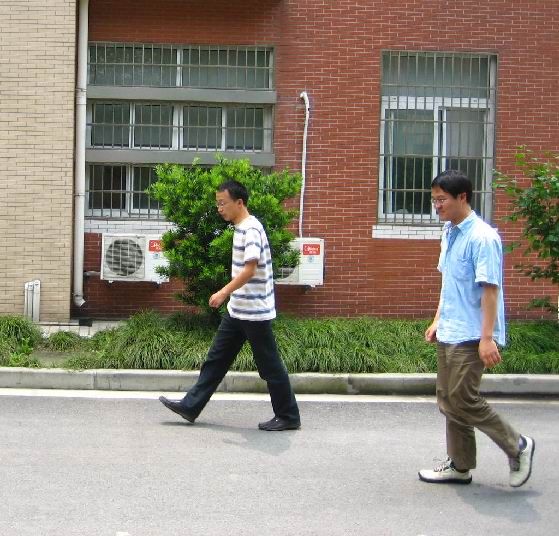

In [3]:
from PIL import Image

Image.open(dataset_root / "PNGImages/FudanPed00001.png")

In [4]:
import numpy as np

mask_array = np.array(Image.open(dataset_root / "PedMasks/FudanPed00001_mask.png"))

In [5]:
mask_array[mask_array != 0].min(), mask_array[mask_array != 0].max()

(1, 2)

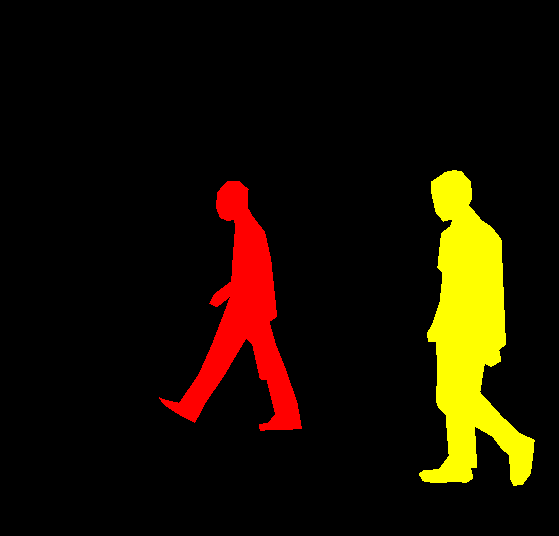

In [6]:
mask = Image.open(dataset_root / "PedMasks/FudanPed00001_mask.png")
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette(
    [
        0,
        0,
        0,  # black background
        255,
        0,
        0,  # index 1 is red
        255,
        255,
        0,  # index 2 is yellow
        255,
        153,
        0,  # index 3 is orange
    ]
)
mask

In [7]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class with lable 1
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
dataset = PennFudanDataset(dataset_root)
dataset[1][1]

{'boxes': tensor([[ 67.,  92., 190., 379.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([1]),
 'area': tensor([35301.]),
 'iscrowd': tensor([0])}

## Defining your model

Здесь будем дообучать [Mask R-CNN](https://arxiv.org/abs/1703.06870), которая основана на [Faster R-CNN](https://arxiv.org/abs/1506.01497) модели. 

![Faster R-CNN](images/fast_rcnn_im1.png)

Mask R-CNN добавляет ещё одну ветку в Faster R-CNN, для предсказания масок сегментации

![Mask R-CNN](images/mask_rcnn_im1.png)

Рассмотрим 2 сценария дообучения предобученной модели
В первом берём предобученную модели и дообучаем последний слой. Во втором случае мы заменяем базовую сеть, извлекающую признаки (backbone), например, для достижения большей скорости предсказания


### 1 - Дообучение предобученной модели

Мы хотим взять предобученную на [COCO](https://cocodataset.org/#explore) модель и дообучить её на новом наборе данных со своими классами:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Изменения модели для добавления нового бекбона

Может оказаться, что backbone (ResNet-50) слишком большой для нашего приложения и мы хотим заменить его на более легковесную сеть


```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### Instance segmentation модель для PennFudan Dataset

В нашем случае набор данных небольшой поэтому мы будем дообучать предобученную модель. Для этого будем пользоваться подходом 1.

Для решения нашей задачи мы будем использовать [Mask R-CNN](https://arxiv.org/abs/1703.06870)

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

## Функции обучения и оценки точности

В  `https://github.com/pytorch/vision/tree/v0.3.0/references/detection` есть полезные функции для обучения и тестирования модели.

Нужные нам файлы были скопированы в рабочую директорию

## Аугментации

In [13]:
import transforms as T
from engine import train_one_epoch, evaluate
import utils


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Тестирование forward() метода 

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(dataset_root, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions

### Обучение модели

У нас есть класс для нового набора данных, модель, преобразователь данных и функции для посчёта точности. Имея всё это мы можем обучить модель

In [15]:
from engine import train_one_epoch, evaluate
import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(dataset_root, get_transform(train=True))
dataset_test = PennFudanDataset(dataset_root, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:00:56  lr: 0.000090  loss: 4.4840 (4.4840)  loss_classifier: 0.8636 (0.8636)  loss_box_reg: 0.3154 (0.3154)  loss_mask: 3.2743 (3.2743)  loss_objectness: 0.0236 (0.0236)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 0.9427  data: 0.4001  max mem: 2301
Epoch: [0]  [10/60]  eta: 0:00:19  lr: 0.000936  loss: 1.8554 (2.5764)  loss_classifier: 0.4916 (0.5241)  loss_box_reg: 0.3012 (0.2910)  loss_mask: 1.0101 (1.7390)  loss_objectness: 0.0225 (0.0174)  loss_rpn_box_reg: 0.0051 (0.0050)  time: 0.3995  data: 0.0410  max mem: 3031
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 1.1322 (1.7458)  loss_classifier: 0.2182 (0.3690)  loss_box_reg: 0.2766 (0.2854)  loss_mask: 0.5246 (1.0627)  loss_objectness: 0.0225 (0.0213)  loss_rpn_box_reg: 0.0056 (0.0073)  time: 0.3543  data: 0.0053  max mem: 3131
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.6948 (1.3671)  loss_classifier: 0.1268 (0.2795)  loss_box_reg: 0.2256 (0.2737)  loss_mask: 0.2203 (0.7895)  loss_ob

In [16]:
torch.save(model.state_dict(), "../data/MaskRCNN_finetune.pt")

In [17]:
model = get_model_instance_segmentation(num_classes=2)
model.load_state_dict(torch.load("../data/MaskRCNN_finetune.pt"))
model.eval();

## Предсказания на тесте

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [23]:
prediction

[{'boxes': tensor([[112.8219,  79.0834, 235.2263, 409.5576],
          [228.8792,  96.8614, 325.6685, 385.6218],
          [  0.0000, 104.8709,  70.0261, 401.8184],
          [436.9549, 107.2619, 595.1308, 423.1235],
          [ 45.8493,  93.0340, 117.9305, 367.3747],
          [516.0944, 133.1069, 601.6081, 339.8790],
          [150.6041,  81.0538, 312.6765, 395.1505],
          [ 26.8374,  80.8598, 167.0106, 390.2564],
          [ 46.5610,  98.8013, 382.3951, 369.0788]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9964, 0.9958, 0.9952, 0.9903, 0.9878, 0.3382, 0.3039, 0.0953, 0.0754],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0.,

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

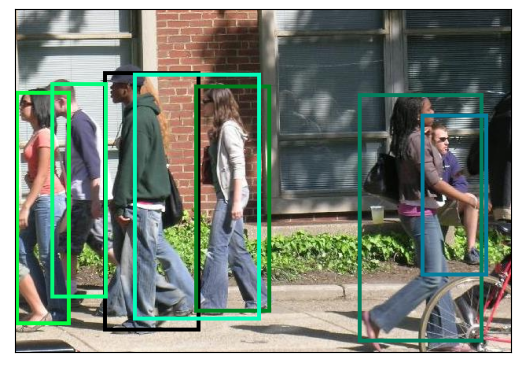

In [25]:
from torchvision.utils import draw_bounding_boxes

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
boxes = prediction[0]["boxes"][prediction[0]["scores"] > 0.2]
result = draw_bounding_boxes(T.PILToTensor()(image)[0], boxes, width=5)

show(result)

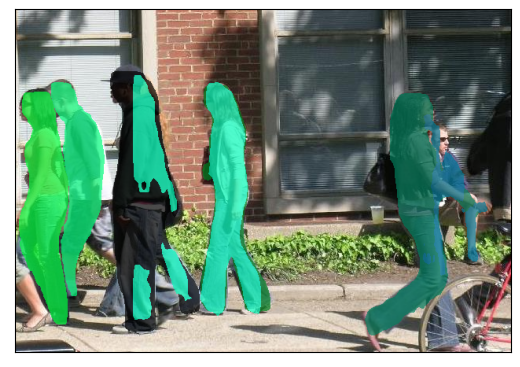

In [27]:
from torchvision.utils import draw_segmentation_masks

masks = (prediction[0]["masks"][prediction[0]["scores"] > 0.2] > 0.5).squeeze(1)
show(draw_segmentation_masks(T.PILToTensor()(image)[0], masks=masks, alpha=0.7))

## Тестирование на изображении не из набор данных

In [28]:
image = Image.open("XaHpf_z51huQS_JPHs-jkPhBp0dLlxFJwt-sPLpGJB0.jpg")
transforms = []
transforms.append(T.PILToTensor())
transforms.append(T.ConvertImageDtype(torch.float))

tr = T.Compose(transforms)
img, _ = tr(image, None)

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

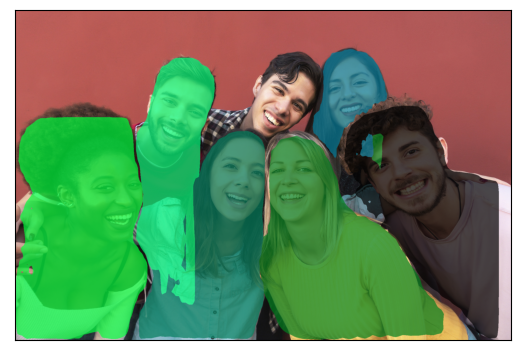

In [33]:
from torchvision.utils import draw_segmentation_masks

masks = (prediction[0]["masks"][prediction[0]["scores"] > 0.1] > 0.5).squeeze(1)
show(draw_segmentation_masks(T.PILToTensor()(image)[0], masks=masks, alpha=0.7))